## Predictor variable selection ## 

#### forward selection (Eforymson 1966; Draper and Smith 1966) ####

Iteratively build up a model by adding one predictor variable at a time, starting one with no predictors.

Run the following 3 steps until you run out of predictors:
1. For each unused predictor, add it to the model to form a candidate model.
2. Tune all of the candidate models.
3. Update the model to be the candidate model with the highest cross-validation accuracy.

Select the model that provides the best trade-off between accuracy and simplicity.

### set-up ###

In [47]:
# loading packages
library(repr)
library(tidyverse)
library(tidymodels)
# library(themis)
set.seed(31)

In [48]:
# loading data
stroke <- read_csv("data/stroke-data.csv")
colnames(stroke)

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)



[1] "id"                "gender"            "age"              
 [4] "hypertension"      "heart_disease"     "ever_married"     
 [7] "work_type"         "Residence_type"    "avg_glucose_level"
[10] "bmi"               "smoking_status"    "stroke"

In [49]:
# cleaning and wrangling
# stroke_clean <- stroke %>%
#     select(gender, age, hypertension, heart_disease, avg_glucose_level, bmi, smoking_status, stroke) %>%
#     mutate(gender = as_factor(gender), 
#            bmi = as.numeric(bmi),
#            smoking_status = as_factor(smoking_status),
#            stroke = as_factor(stroke)) %>%
#     filter(gender != "Other") #Other was removed as there was only one occurrence in the dataset

# prep and bake data with upsampling, then use it with everything
# gonna overfit data, data leakage
stroke_clean <- stroke %>%
    select(age, hypertension, heart_disease, avg_glucose_level, bmi, stroke) %>%
    mutate(stroke = as_factor(stroke),
           bmi = as.numeric(bmi)) 

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [68]:
head(stroke_clean)

age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.3784336,-0.3350744,4.0915769,-0.58622986,NA,0
1.1708731,-0.3350744,-0.2443408,-0.08416999,1.1691436,0
-0.6781525,-0.3350744,-0.2443408,-0.45391087,-0.2754355,0
-0.7221769,-0.3350744,-0.2443408,-0.91127435,1.5986130,0
-0.8542502,-0.3350744,-0.2443408,0.18223815,0.1670482,0
0.2903847,-0.3350744,-0.2443408,-1.07036692,-0.1583074,0


#### Split data

In [72]:
stroke_split <- initial_split(stroke_clean, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

### Downsampling

In [76]:
ds_recipe <- recipe(stroke ~ ., data = stroke_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    step_downsample(stroke, under_ratio = 1, skip = FALSE) %>%
    prep()
dsampled_stroke <- bake(ups_recipe, stroke_train)

In [75]:
dsampled_stroke <- bake(ups_recipe, stroke_train)

upsampled_stroke %>%
  group_by(stroke) %>%
  summarize(n = n())

head(upsampled_stroke)
tail(upsampled_stroke)

`summarise()` ungrouping output (override with `.groups` argument)



stroke,n
<fct>,<int>
0,3644
1,3644


age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.7787630,-0.3350744,-0.2443408,-0.2474667,-1.4076731,0
0.6425801,2.9836336,-0.2443408,-0.4058954,1.3513427,0
-1.5586409,-0.3350744,-0.2443408,0.1014749,-1.4597300,0
1.1708731,-0.3350744,-0.2443408,-0.8245368,0.9218733,0
0.3784336,-0.3350744,-0.2443408,-0.6353516,-1.4467158,0
1.3909952,-0.3350744,4.0915769,3.0363899,-0.2363928,0


age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.5985557,-0.3350744,-0.2443408,-0.84710628,1.1301009,1
0.8627022,-0.3350744,-0.2443408,0.00610785,-0.6398338,1
0.5545313,-0.3350744,-0.2443408,1.74506268,1.5075134,1
1.1268487,2.9836336,4.0915769,-0.75527955,1.0390013,1
1.6551417,-0.3350744,-0.2443408,-0.79665689,-0.3925635,1
0.6866045,-0.3350744,-0.2443408,-0.22445468,1.9890398,1


### Forward Selection

In [70]:
# DOWNSAMPLE here!!!

In [57]:
stroke_subset <- upsampled_stroke %>%
    filter(!is.na(bmi))
names <- colnames(upsampled_stroke %>% select(-stroke)) %>% sort()
names

[1] "age"               "avg_glucose_level" "bmi"              
[4] "heart_disease"     "hypertension"

In [58]:
example_formula <- paste("stroke", "~", paste(names, collapse="+"))
example_formula

[1] "stroke ~ age+avg_glucose_level+bmi+heart_disease+hypertension"

In [59]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>


In [60]:
# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
stroke_vfold <- vfold_cv(stroke_subset, v = 5, strata = stroke)

gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 2))

In [61]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

In [62]:
set.seed(31)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    print("start")
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        print(model_string)
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

#         !!! how can i repeat the below step more to make it more accurate?
        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = gridvals) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    print("unlist")
    print(unlist(accs))
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

In [ ]:
accuracies

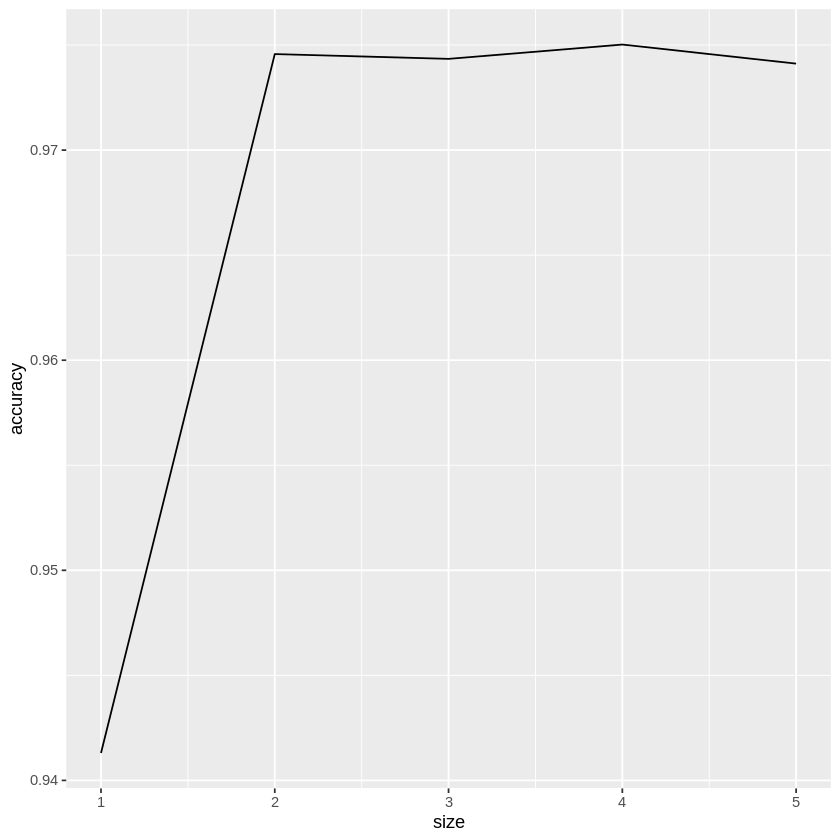

In [165]:
ggplot(accuracies, aes(x=size, y=accuracy)) +
geom_line()

## with predict ##

In [63]:
stroke_recipe <- recipe(stroke ~ avg_glucose_level + age, data = stroke_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

In [42]:
stroke_vfold <- vfold_cv(stroke_train, v = 5, strata = stroke)
k_vals <- tibble(neighbors = seq(from = 100, to = 200, by = 5))

In [43]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

In [ ]:
knn_results <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = stroke_vfold, grid = k_vals) %>%
  collect_metrics() 
knn_results

In [29]:
accuracies <- knn_results %>% # Plot accuracies vs neighbours
  filter(.metric == "accuracy")
optimal_neighbours <- accuracies %>%
  filter(mean == max(mean))
optimal_neighbours

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.9538097,5,0.002285071,Model009
10,accuracy,binary,0.9538097,5,0.002285071,Model010
11,accuracy,binary,0.9538097,5,0.002285071,Model011
12,accuracy,binary,0.9538097,5,0.002285071,Model012
13,accuracy,binary,0.9538097,5,0.002285071,Model013
14,accuracy,binary,0.9538097,5,0.002285071,Model014
15,accuracy,binary,0.9538097,5,0.002285071,Model015
16,accuracy,binary,0.9538097,5,0.002285071,Model016
17,accuracy,binary,0.9538097,5,0.002285071,Model017


In [ ]:
stroke_test_predictions <- predict(knn_fit, stroke_test) %>%
  bind_cols(stroke_test)

stroke_test_predictions %>%
  metrics(truth = stroke, estimate = .pred_class) %>%
  filter(.metric == "accuracy") %>%
  arrange(desc(mass))

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies